# Africa Credit Challenge

The goals of this `starter notebook` are:

1. How to load data into a `Pandas` dataframe

2. How to `train` a basic machine learning model

3. How to `evaluate` the model

4. How to `save` your __submission__ following the required format.

<font color="red"><b>Note: This is just a starter notebook. It is by no means an ideal solution.</b></font>

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

## Load and Inspect the data

In [5]:
# Loading the train dataset
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')
# Display the first few rows of the datasets and their shape
display("Train", train.head(), train.shape, "Test", test.head(), test.shape)

'Train'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


(68654, 16)

'Test'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


(18594, 15)

In [6]:
# Check column types & missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

In [7]:
# Are there missing values in the train dataset ?
print(f"There are {train.isna().sum().sum()} missing values in the data.")

There are 0 missing values in the data.


### EDA

In [8]:
def plot_continuous(df, column, transform=None):
    """
    Plots visualizations for a continuous variable, showing the distribution and boxplot for both
    the original and transformed versions of the data.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The column name of the continuous variable to plot.
        transform (str, optional): Transformation to apply to the data before plotting.
                                  Accepted values are 'log' or 'sqrt'. Default is None, which means no transformation.

    This function generates:
        - A histogram with a kernel density estimate (KDE) for the original data.
        - A boxplot for the original data.
        - If a transformation is specified ('log' or 'sqrt'):
            - A histogram with a KDE for the transformed data.
            - A boxplot for the transformed data.
    """
    # Create subplots for visualizations
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))

    # Original data plots
    sns.histplot(df[column], kde=True, ax=axs[0, 0])
    axs[0, 0].set_title(f'Distribution of {column}')
    axs[0, 0].set_xlabel(column)

    sns.boxplot(y=df[column], ax=axs[1, 0])
    axs[1, 0].set_title(f'Box Plot of {column}')
    axs[1, 0].set_ylabel(column)

    # Transformations (log or square root)
    if transform == 'log':
        transformed_data = np.log1p(df[column])  # log1p handles log(0) gracefully
        transform_label = 'Log'
    elif transform == 'sqrt':
        transformed_data = np.sqrt(df[column])  # Square root transformation
        transform_label = 'Square Root'
    else:
        transformed_data = None  # No transformation if not specified

    # If transformed data exists, generate corresponding plots
    if transformed_data is not None:
        sns.histplot(transformed_data, kde=True, ax=axs[0, 1])
        axs[0, 1].set_title(f'{transform_label} Distribution of {column}')
        axs[0, 1].set_xlabel(f'{transform_label}({column})')

        sns.boxplot(y=transformed_data, ax=axs[1, 1])
        axs[1, 1].set_title(f'{transform_label} Box Plot of {column}')
        axs[1, 1].set_ylabel(f'{transform_label}({column})')
    else:
        # If no transformation, remove the second set of axes
        for ax in [axs[0, 1], axs[1, 1]]:
            ax.remove()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


def plot_categorical(df, column):
    """
    Plots visualizations for a categorical variable, including a bar plot and a pie chart.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The column name of the categorical variable to plot.

    This function generates:
        - A bar plot showing the counts of each category in the specified column.
        - A pie chart showing the relative proportions of each category.
    """
    # Create subplots for visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Bar plot showing counts of each category
    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax1)
    ax1.set_title(f'Bar Plot of {column}')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Pie chart showing percentage distribution of each category
    ax2.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
    ax2.set_title(f'Pie Chart of {column}')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


#### Categorical exploration

# Understand the Target Variable
Before we can do anything we first have to understand the column we are trying to predict. 
- The question to answer is: Out of all the loans in our training data, how many actually defaulted?

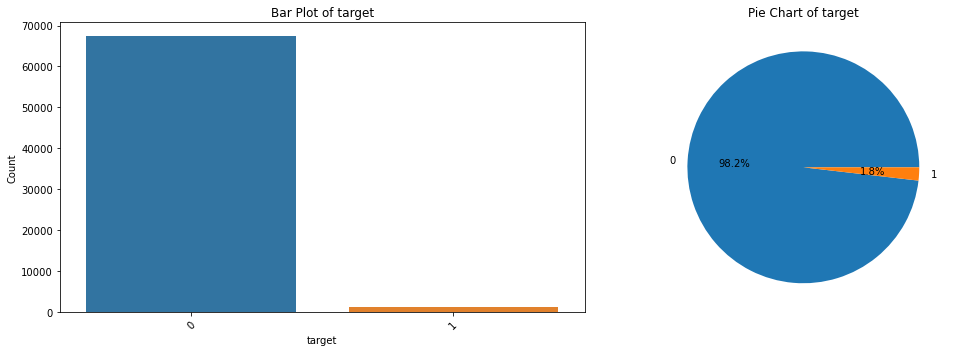

In [20]:
plot_categorical(train, 'target')

## ***Analysis***:
The dataset is highly imbalanced. 
The vast majority of the customers are good(98.2%) 
The real problem is in finding the tiny fraction (1.8%) of customers who will cause the financial institutions to lose money.


## **Consequences of this imbalance**:
- **Evaluation metric**: The F1-score is choosen as it forces our model to get good at predicting both classes and not just the majority class

- **Modeling strategy**: Techniques used to handle the imbalance are:
  - using stratified cross-validation
  - using algorithms that handle imbalance well (e.g., tree-based algorithms)
  - using advanced resampling techniques (e.g., SMOTE, ADASYN)
  - using anomaly detection algorithms (e.g., Isolation Forest, One-Class SVM)
  - using cost-sensitive learning (e.g., adjusting class weights in algorithms like logistic regression, decision trees, and support vector machines)
  - using ensemble methods (e.g., Random Forest, Gradient Boosting) that can handle imbalance better than single models
  - using threshold moving to adjust the decision threshold for classification
  - using evaluation metrics that are more appropriate for imbalanced datasets (e.g., precision, recall, F1-score, ROC-AUC)
  - using data augmentation techniques to generate synthetic samples of the minority class
  - using feature engineering to create new features that can help distinguish between the classes better
  - using domain knowledge to identify important features and relationships in the data that can help improve model performance
  - using hyperparameter tuning to optimize model performance for the imbalanced dataset
  - using cross-validation techniques that are appropriate for imbalanced datasets(e.g., stratified k-fold cross-validation)
  - using ensemble methods that combine multiple models to improve performance on imbalanced datasets (e.g., bagging, boosting)
  - using transfer learning to leverage pre-trained models on similar tasks to improve performance on the imbalanced dataset
  - using active learning to iteratively select the most informative samples for labeling and training the model
  - using semi-supervised learning to leverage both labeled and unlabeled data to improve model performance on the imbalanced dataset
  - using deep learning techniques that can handle imbalanced datasets (e.g., convolutional neural networks, recurrent neural networks)
  - using explainable AI techniques to understand how the model is making predictions and identify potential biases in the data
  - using regularization techniques to prevent overfitting and improve generalization on the imbalanced dataset
  - data cleaning to remove noise and outliers that can negatively impoct model performance on the imbalanced dataset
  - using feature selection techniques to identify the most importnant features for the imbalanced dataset
  - data visualization that can help identify patterns and relationships in the data that can improve model performance on the imbalanced dataset.
  - using ensemble methods that combine multiple techniques to improve performance on imbalanced datasets (e.g., SMOTE + cost-sensitive learning + ensemble methods)
  - using a combination of the above techniques to improve model performance on the imbalanced dataset. 

In [22]:
# Assume 'train_df' is your loaded training DataFrame

# Select columns with numerical data types
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
num_numerical_features = len(numerical_features)

# Select columns with categorical/text data types
categorical_features = train.select_dtypes(include=['object']).columns
num_categorical_features = len(categorical_features)

print(f"Found {num_numerical_features} numerical features:")
print(list(numerical_features))

print("\n------------------------------------\n")

print(f"Found {num_categorical_features} categorical features:")
print(list(categorical_features))

Found 10 numerical features:
['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'target']

------------------------------------

Found 6 categorical features:
['ID', 'country_id', 'loan_type', 'disbursement_date', 'due_date', 'New_versus_Repeat']


## **Find predictive Signal (Numerical Feature vs. Target)**
We investigate the relationship between each numerical feature and the target variable to see which are most predictive of loan default. 

- For which of our features do defaulters look the most different from people who pay back?


In [21]:
# Identify numerical columns (excluding IDs and the target itself)
numerical_cols = train.select_dtypes(include=['number']).columns.drop(['customer_id', 'tbl_loan_id', 'lender_id', 'target'])

# Group by target and calculate the mean for each numerical column
grouped_stats = train.groupby('target')[numerical_cols].mean()

# Calculate the absolute difference in means between the two target classes
mean_difference = abs(grouped_stats.loc[0] - grouped_stats.loc[1])

# Sort the features by the difference in their means
sorted_differences = mean_difference.sort_values(ascending=False)

# Display the results
print("Features with the largest difference in mean between Defaulters and Non-Defaulters:")
print(sorted_differences)

Features with the largest difference in mean between Defaulters and Non-Defaulters:
Total_Amount_to_Repay          107190.593765
Total_Amount                    90873.954680
Lender_portion_to_be_repaid     10925.598099
Amount_Funded_By_Lender          9053.549695
duration                           18.891401
Lender_portion_Funded               0.043966
dtype: float64


## Visualizing the differences

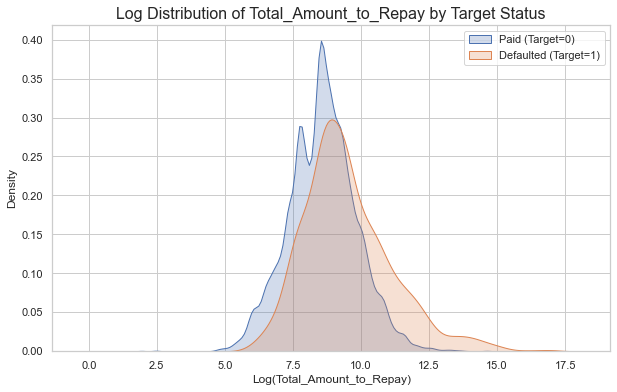

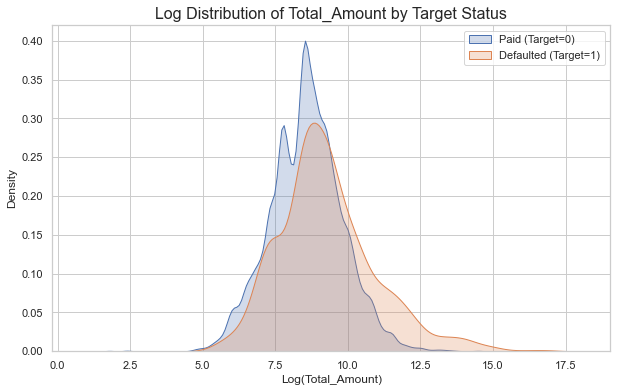

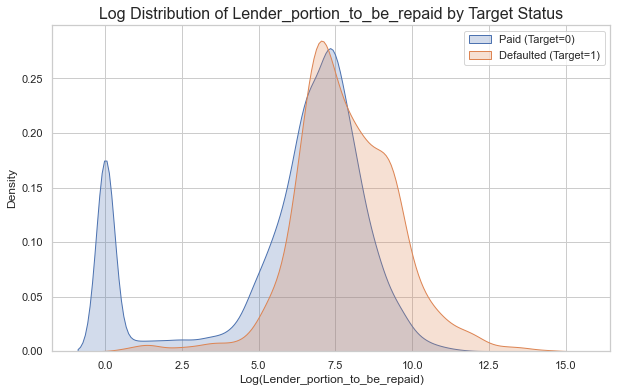

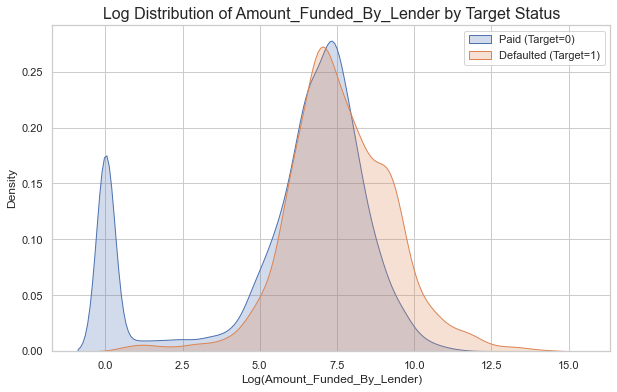

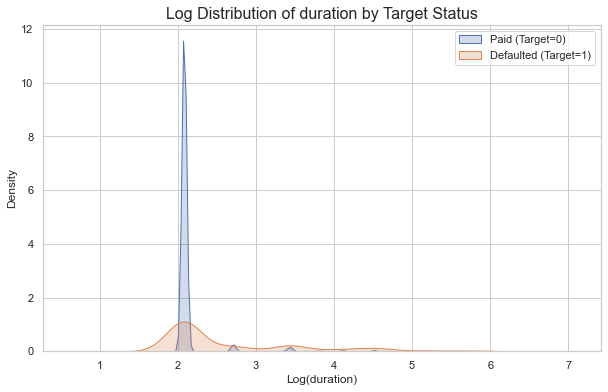

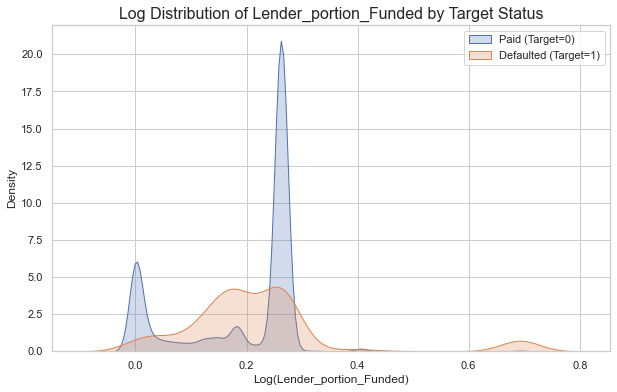

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# The list of numerical features we want to investigate
features_to_plot = [
    'Total_Amount_to_Repay',
    'Total_Amount',
    'Lender_portion_to_be_repaid',
    'Amount_Funded_By_Lender',
    'duration',
    'Lender_portion_Funded'
]

# Loop through each feature and plot its log distribution
for col in features_to_plot:
    plt.figure(figsize=(10, 6))
    
    # Apply log transformation to the column for both groups
    sns.kdeplot(np.log1p(train[train['target'] == 0][col]), label='Paid (Target=0)', shade=True)
    sns.kdeplot(np.log1p(train[train['target'] == 1][col]), label='Defaulted (Target=1)', shade=True)
    
    # Update title and labels to reflect the transformation
    plt.title(f'Log Distribution of {col} by Target Status', fontsize=16)
    plt.xlabel(f'Log({col})', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.show()


#### **Overall Finding**

The exploratory data analysis reveals clear differences in the distributions of several key numerical features between loans that were paid back (Target=0) and loans that defaulted (Target=1). By plotting these features on a logarithmic scale, we can overcome the data skewness and identify strong predictive signals that will be crucial for our machine learning model.


#### **1. Loan Amounts (Total_Amount & Total_Amount_to_Repay)**

- **Observation:** The distributions for the "Paid" group (blue) are narrower and have a higher peak at a lower loan amount compared to the "Defaulted" group (orange). The orange curve is flatter and shifted to the right, indicating a wider range of loan amounts and a tendency towards higher amounts.
    
- **Business Takeaway:** **Customers who default tend to take out larger loans on average than customers who pay back.** The higher the loan amount, the higher the potential risk. This is a very strong and intuitive predictor for our model.
    

#### **2. Loan Duration (duration)**

- **Observation:** The "Paid" group (blue) shows an extremely sharp and high peak at a Log(duration) of around 2.0 (which corresponds to a duration of approx. 7 days, since e^2 ≈ 7.4). The "Defaulted" group (orange) has a much lower, wider peak and a thicker "tail," indicating that defaults occur across a wider range of loan durations.
    
- **Business Takeaway:** **The vast majority of successful loans are very short-term (around 7 days).** While defaults also happen with short-term loans, a longer loan duration is a significant risk factor.
    


#### **3. Lender Funding (Amount_Funded_By_Lender & Lender_portion_to_be_repaid)**

- **Observation:** This is a very interesting pattern. The "Paid" group (blue) has a distinct peak at Log(Amount) equal to 0 (which means the original amount was 0), and then another larger peak around 7-8. The "Defaulted" group (orange) has almost no density at 0 and its main peak is slightly to the right of the "Paid" group's main peak.
    
- **Business Takeaway:** **Loans where the lender funded little to nothing (Amount ≈ 0) are very likely to be paid back.** When the lender does fund an amount, defaulters tend to have slightly higher amounts funded by the lender than non-defaulters.
    


#### **4. Lender Portion Funded (Lender_portion_Funded)**

- **Observation:** This plot is now much clearer. The "Paid" group (blue) has three distinct behaviors: a peak near 0, another small peak, and a very large peak around Log(0.3) which is approx -1.2. The "Defaulted" group (orange) has a wider, more spread-out distribution.
    
- **Business Takeaway:** The funding strategy appears to be a key indicator. **Customers who default have a more varied and less predictable lender funding portion.** In contrast, good customers seem to fall into very specific funding brackets.
    


In [34]:
# Display the unique value counts and their sum for each categorical feature in the train dataset

categorical_features = train.select_dtypes(include=['object']).columns

for col in categorical_features:
    value_counts = train[col].value_counts()
    print(f"Column: {col}")
    print(value_counts)
    print(f"Number of unique values: {train[col].nunique()}")
    print("-" * 40)

Column: ID
ID_260753264964267278    1
ID_14362295742267278     1
ID_241716247823267278    1
ID_256081250546267278    1
ID_248952273156267278    1
                        ..
ID_254347287663267278    1
ID_268178280877267278    1
ID_251213258453267278    1
ID_247817245385267278    1
ID_273584360776267278    1
Name: ID, Length: 68654, dtype: int64
Number of unique values: 68654
----------------------------------------
Column: country_id
Kenya    68654
Name: country_id, dtype: int64
Number of unique values: 1
----------------------------------------
Column: loan_type
Type_1     61723
Type_7      2790
Type_5      1521
Type_4      1235
Type_10      466
Type_6       357
Type_9       205
Type_14       99
Type_2        74
Type_11       42
Type_18       30
Type_17       23
Type_12       21
Type_23       18
Type_20       13
Type_16       12
Type_13       10
Type_15        4
Type_19        4
Type_21        3
Type_24        3
Type_22        1
Name: loan_type, dtype: int64
Number of unique values: 22

### **Find a Predictive Signal (Categorical Feature vs. Target)**
- Just like with numerical features, we want to know if the proportion of defaulters is different acros various categories.


Analyzing the following categorical features: ['loan_type', 'New_versus_Repeat']


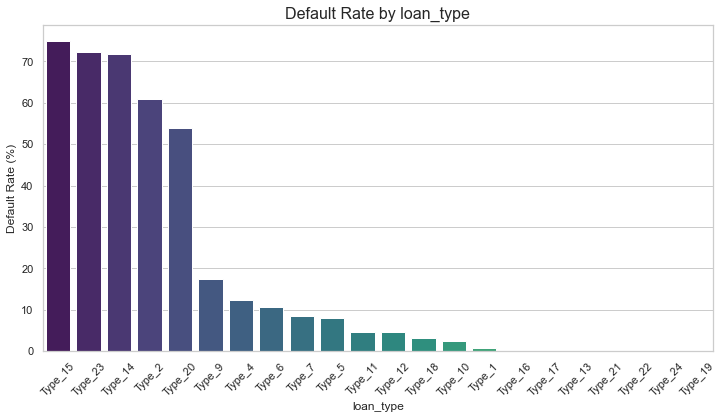

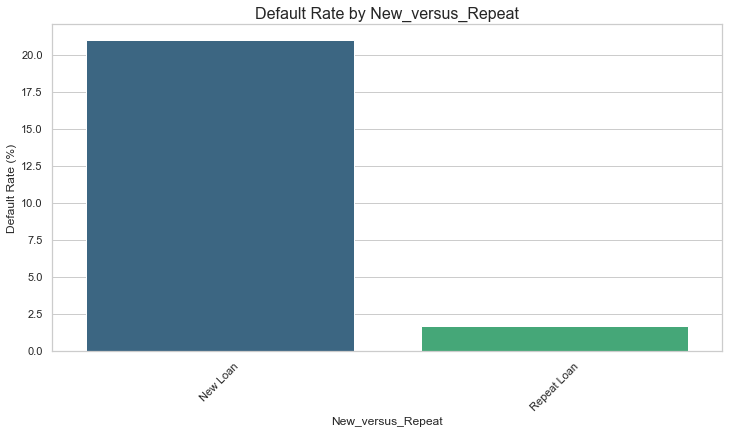

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical_vs_target(df, column_name):
    """
    Plots the default rate (percentage of target=1) for each category 
    of a specified column.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to plot.
    """
    plt.figure(figsize=(12, 6))
    
    # Calculate the default rate for each category and sort it
    default_rate = df.groupby(column_name)['target'].mean().sort_values(ascending=False) * 100
    
    # Create the bar plot
    sns.barplot(x=default_rate.index, y=default_rate.values, palette="viridis")
    
    plt.title(f'Default Rate by {column_name}', fontsize=16)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Default Rate (%)', fontsize=12)
    plt.xticks(rotation=45) 
    plt.show()

# --- Now, let's use the function ---

# First, get a list of all categorical columns
all_categorical_features = train.select_dtypes(include=['object']).columns

# Create a list of features to plot.
# We exclude columns like 'ID' because they have too many unique values to be useful here,
# and we already know 'country_id' only has one value in the training set.
# The date columns are also not suitable for this type of bar chart.    
features_to_plot = ['loan_type', 'New_versus_Repeat']


# Loop through our list of relevant categorical features and create a plot for each
print(f"Analyzing the following categorical features: {features_to_plot}")
for col in features_to_plot:
    plot_categorical_vs_target(train, col)

## ***Analyze Categorical Features***

Analysis of the key categorical features reveals strong relationships between the loan characteristics and the probability of default. These features will be highly valuable for our predictive model.


#### **1. Default Rate by New_versus_Repeat**

- **Observation:** The bar chart shows a dramatic difference in default rates. "New Loan" customers have a default rate of over **20%**, while "Repeat Loan" customers have a default rate of less than **2%**.
    
- **Business Takeaway:** This is arguably the **strongest single predictor of risk** we have seen so far. Customers with no prior borrowing history with the lender are more than **10 times more likely to default** than existing customers. Our model must pay very close attention to this feature. It confirms the common business wisdom that past performance is a key indicator of future reliability.
    

#### **2. Default Rate by loan_type**

- **Observation:** There is a very wide variance in risk across different loan types.
    
    - **High-Risk Loans:** Type_15, Type_23, and Type_14 have extremely high default rates, exceeding **70%**. Type_2 and Type_20 are also very high-risk, with default rates over 50%.
        
    - **Low-Risk Loans:** Type_1, which is the most common loan type in the dataset, has a very low default rate (close to 1%). Many other loan types (Type_16, Type_17, etc.) have a 0% default rate in the training data, though this might be due to having very few samples.
        
- **Business Takeaway:** The specific product or type of loan a customer applies for is a critical indicator of risk. The model can learn to assign a much higher risk score to customers applying for Type_15 or Type_23 loans compared to the much safer Type_1 loans. This information could be used by the business to either tighten lending criteria for high-risk products or to re-evaluate the profitability of offering them at all.

## **FEATURE ENGINEERING**
### **DATE-BASED FEATURES**

- The disbursement_date and due_date columns are not useful in their raw form. However, we can extract meaningful features from them that may help our model. 

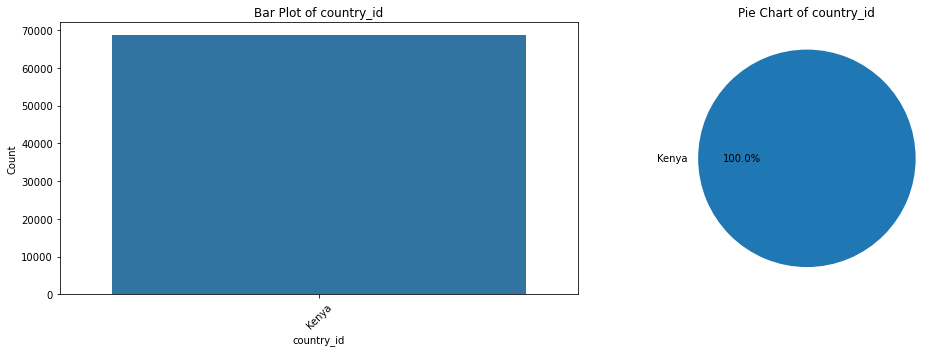

In [9]:
plot_categorical(train, 'country_id')

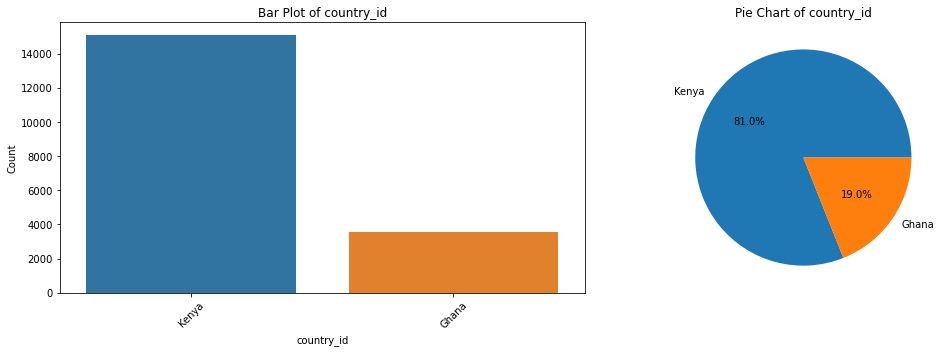

In [10]:
plot_categorical(test, 'country_id')

##### This shows that test has a new country, ghana so one of the goals is to build a solution that can generalize well in new regions

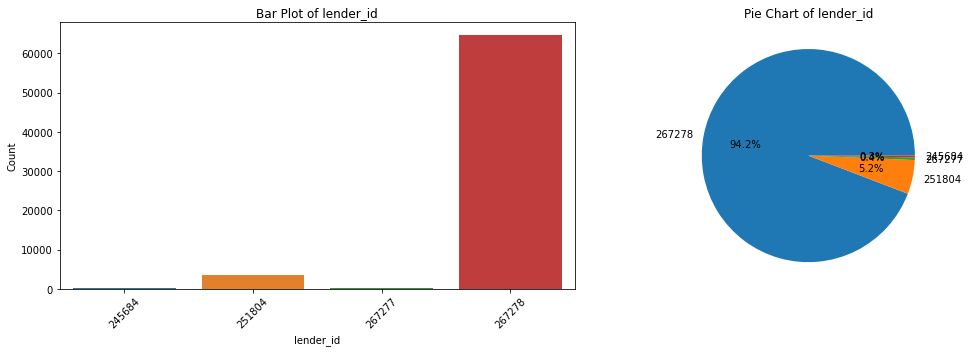

In [11]:
plot_categorical(train, 'lender_id')

##### You can exploree more of the categorical columns as well

#### TARGET EXPLORATION


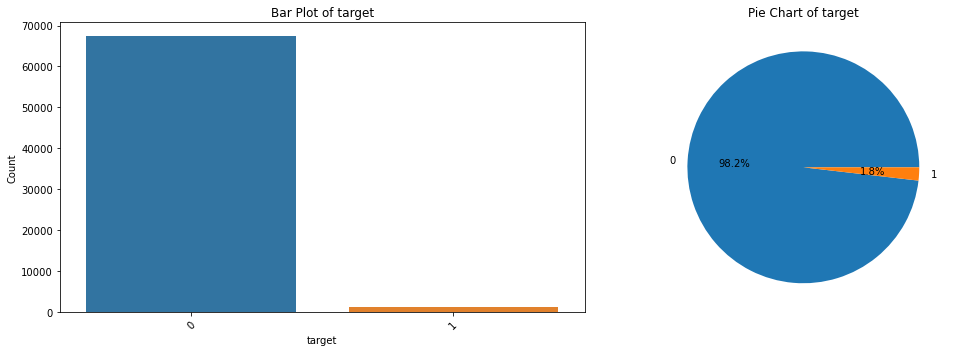

In [12]:
plot_categorical(train, 'target')

##### You can see the dataset is highly imbalanced , and this is expected in loan default scenarios, So find  ways to deal with the  imbalance

### CONTINUOUS COLUMN EXPLORATION

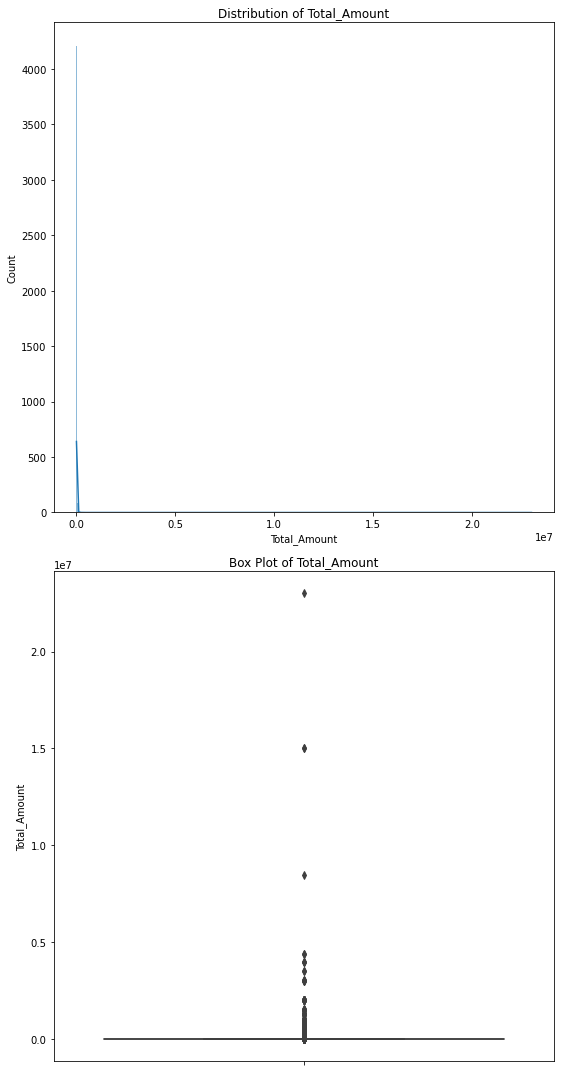

In [13]:
plot_continuous(train, 'Total_Amount')

Are those outliers?
##### You can explore more of the given numerical columns as well

### Feature Engineering
* So here we are going to concatenate both the train and test so that we can do the processing once instead of repeating for each

In [14]:
data = pd.concat([train, test]).reset_index(drop=True)

# Convert the datetime columns appropriately
date_cols = ['disbursement_date', 'due_date']
for col in date_cols:
    data[col] = pd.to_datetime(data[col])
    # Extract month, day, and year from the date columns
    data[col+'_month'] = data[col].dt.month
    data[col+'_day'] = data[col].dt.day
    data[col+'_year'] = data[col].dt.year

# Select all categorical columns from the dataset and label encode them or one hot encode
cat_cols = data.select_dtypes(include='object').columns
num_cols = [col for col in data.select_dtypes(include='number').columns if col not in ['target']]
print(f"The categorical columns are: {cat_cols}.")
print("-"* 100)
print(f"The numerical columns are: {num_cols}")
print("-"* 100)
# we are going to one  hot encode the loan type
data = pd.get_dummies(data, columns=['loan_type'], prefix='loan_type', drop_first=False)
# Convert all the columns with prefix loan_type_ to 0/1 instead of False/True
loan_type_cols = [col for col in data.columns if col.startswith('loan_type_')]
data[loan_type_cols] = data[loan_type_cols].astype(int)

# Label-encoding for the other remaining categorical columns
le = LabelEncoder()
for col in [col for col in cat_cols if col not in ['loan_type', 'ID']]:
    data[col] = le.fit_transform(data[col])


# deal with numerical columns: we saw loan amount is  highly right skewed for this we can log transform it
data['Total_Amount'] = np.log1p(data['Total_Amount']) # study other numerical columns and see if they are skewed as well

# Splitting the data back into train and test
train_df = data[data['ID'].isin(train['ID'].unique())]

test_df = data[data['ID'].isin(test['ID'].unique())]

# we are also going to drop the country id as we saw we have only one country in train
features_for_modelling = [col for col in train_df.columns if col not in date_cols + ['ID', 'target', 'country_id']]

# Check if the new datasets have the same rows as train and test datasets
print(f"The shape of train_df is: {train_df.shape}")
print(f"The shape of test_df is: {test_df.shape}")
print(f"The shape of train is: {train.shape}")
print(f"The shape of test is: {test.shape}")
print(f"The features for modelling are:\n{features_for_modelling}")


The categorical columns are: Index(['ID', 'country_id', 'loan_type', 'New_versus_Repeat'], dtype='object').
----------------------------------------------------------------------------------------------------
The numerical columns are: ['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'disbursement_date_month', 'disbursement_date_day', 'disbursement_date_year', 'due_date_month', 'due_date_day', 'due_date_year']
----------------------------------------------------------------------------------------------------
The shape of train_df is: (68654, 45)
The shape of test_df is: (18594, 45)
The shape of train is: (68654, 16)
The shape of test is: (18594, 15)
The features for modelling are:
['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'New_versus_Repeat', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_

### CROSS VALIDATION
* Here we are going to use a simple train test split but due to the imbalance try other robust methods like StratifiedKFold


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features_for_modelling], train['target'], stratify=train['target'], shuffle=True, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(51490, 40) (17164, 40) (51490,) (17164,)


## Initialisation & Model Training

F1 Score: 0.2616
ROC AUC Score: 0.9285

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96     16849
           1       0.16      0.80      0.26       315

    accuracy                           0.92     17164
   macro avg       0.58      0.86      0.61     17164
weighted avg       0.98      0.92      0.94     17164



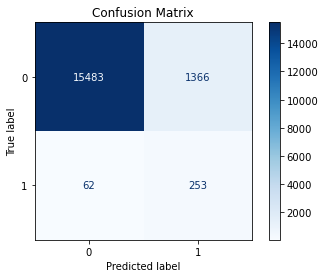

In [16]:

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Logistic Regression Classifier
clf = LogisticRegression(
    random_state=42,
    class_weight="balanced",  # Handle class imbalance
)
clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = clf.predict(X_valid_scaled)
y_pred_proba = clf.predict_proba(X_valid_scaled)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_valid,
    y_pred,
    display_labels=clf.classes_,
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()


### FEATURE IMPORTANCE

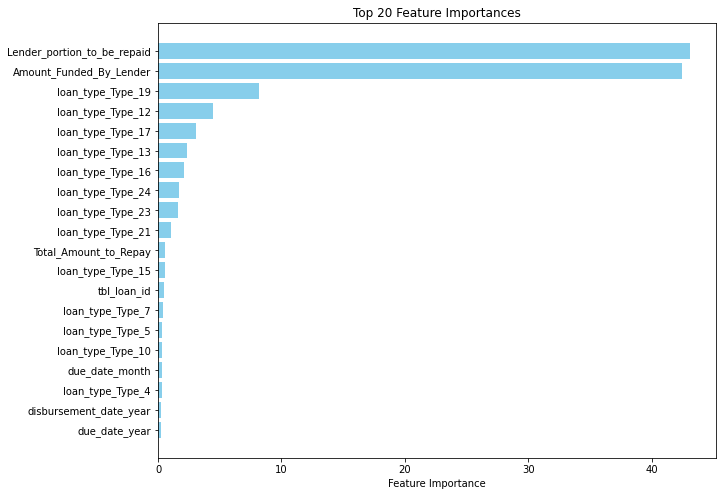

In [17]:
# Feature Importance

# Get the absolute values of the coefficients
feature_importances = np.abs(clf.coef_).flatten()

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': features_for_modelling,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()

## Model Prediction & Inference

In [18]:
# Make predictions on the test dataset
test_predictions = clf.predict(test_df[features_for_modelling])
test_predictions_proba = clf.predict_proba(test_df[features_for_modelling])[:, 1]

# Save the predictions to a CSV file

test_df['target'] = test_predictions
sub =  test_df[['ID', 'target']]
sub.head()


,ID,target
68654,ID_269404226088267278,0
68655,ID_255356300042267278,0
68656,ID_257026243764267278,0
68657,ID_264617299409267278,0
68658,ID_247613296713267278,0


In [19]:
sub.to_csv('baseline_submission.csv', index=False)

#### To Do
* Handle imbalance
* Do more feature engineering
* Use more sophisticated machine learning algorithms
##### Good luck

train['target].value_counts()